![lyon2 geonum](https://perso.liris.cnrs.fr/lmoncla/GEONUM/fig/logos.png)

# 2F2 – Gestion et traitement des données spatio-temporelles1

## Tutoriel : Analyse des données des disponibilités des stations Vélo'v de la Métropole de Lyon

# Partie 3 : Un peu de science des données


L'objectif de cette partie du tutoriel est de continuer l'analyse des données velo'v et d'expérimenter des méthodes d'intelligence artificielle : ajouter une couche de données météo pour faire de la prédiction des disponibilités vélo'v.

Les objectifs de cette partie sont les suivants : 

* Récupérer le jeu de données météo et l'associer à celui des velo'v.
* Visualiser les données selon cette nouvelle couche météo.
* Entraîner un modèle de prédiction de la demande des vélo'v.


## 1. Configurer l'environnement


### 1.1 Importer les librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import plotly.express as px
import seaborn as sn
import wget

## 2. Récupération des jeux de données


* Télécharger les fichiers contenant les données
1. data-stations.zip
2. data-bikes-2.zip
3. data-weather-lyon.csv

Les 2 zip contiennent chacun un fichier CSV contenant respectivement la liste des stations vélov (et leur localisation) et la liste des disponibilités de chaque station par tranche de 30 minutes.


In [7]:
## On télécharge l'archive contenant la liste des stations
wget.download("https://perso.liris.cnrs.fr/lmoncla/GEONUM/data-stations.zip",out="../data/")
    
## On télécharge l'archive contenant la liste des disponibilité des stations par tranche de 5 minutes
wget.download("https://perso.liris.cnrs.fr/lmoncla/GEONUM/data-bikes-2.zip",out="../data")

'../data/data-bikes-2 (1).zip'

### 2.1. Chargement des données

Nous chargeons les mêmes jeux de données que dans le tutoriel précédent :

1. les stations vélo'v (id station, latitude, longitude),
2. leurs historiques (id station, année, mois, jour, heure, minute, date, vélos disponibles, places disponibles).


In [3]:
## On charge les données des stations dans un dataframe
df_stations = pd.read_csv('../data/data-stations.zip')

## On crée maintenant le dataframe avec les données d'historique
df_bikes = pd.read_csv('../data/data-bikes-2.zip')

In [4]:
## On affiche les premières lignes
df_bikes.head

<bound method NDFrame.head of             id_velov  year  month  day  hour  minute  \
0        velov-10001  2021      1    1     0       0   
1        velov-10001  2021      1    1     0      30   
2        velov-10001  2021      1    1     1       0   
3        velov-10001  2021      1    1     1      30   
4        velov-10001  2021      1    1     2       0   
...              ...   ...    ...  ...   ...     ...   
7800247   velov-9052  2022      1    1    23       0   
7800248   velov-9052  2022      1    1    23      30   
7800249   velov-9052  2022      1    1    23      30   
7800250   velov-9052  2022      1    2     0       0   
7800251   velov-9052  2022      1    2     0       0   

                              time  bikes  bike_stands  departure30min  \
0        2021-01-01 00:00:00+00:00      8           22               0   
1        2021-01-01 00:30:00+00:00      8           22               0   
2        2021-01-01 01:00:00+00:00      7           23               1   
3

In [5]:
# Réduction de la taille en mémoire

## on transforme le type des colonnes en entier ou float lorsque cela est nécessaire
df_bikes['time'] = pd.to_datetime(df_bikes['time']) 
df_bikes[['year', 'daily_departure', 'daily_arrival']] = df_bikes[['year', 'daily_departure', 'daily_arrival']].astype('int16')
df_bikes[['month','day','hour','minute', 'bikes', 'bike_stands', 'departure30min','arrival30min', 'day_of_week']] = df_bikes[['month','day','hour','minute', 'bikes', 'bike_stands', 'departure30min','arrival30min', 'day_of_week']].astype('int8')


## 3. Ajout d'une couche de données supplémentaire : la météo


### 3.1 Chargement des données


Le fichier `data-weather-lyon.csv` contient les données météo par heure pour l'année 2021 pour Lyon.

Le jeu de données météo correspond au dataset `NASA/POWER CERES/MERRA2 Native Resolution Hourly Data` récupéré grâce à l'API du site POWER Project de la NASA : https://power.larc.nasa.gov/.




In [6]:
## On télécharge l'archive contenant les données météo
wget.download("https://perso.liris.cnrs.fr/lmoncla/GEONUM/data-weather-lyon.csv",out = "../data/data-weather-lyon.csv")

'../data/data-weather-lyon (1).csv'

In [7]:
## On charge les données météo dans un dataframe
df_weather = pd.read_csv('../data/data-weather-lyon.csv')


In [8]:
## On affiche les premières lignes
df_weather.head()

,YEAR,MO,DY,HR,WD10M,T2M,RH2M,QV2M,T2MDEW,U10M,PS,T2MWET,WS10M,V10M,PRECTOTCORR
0,2021,1,1,0,322.47,-0.35,100.00,3.91,-0.37,0.98,95.48,-0.36,1.62,-1.28,0.94
1,2021,1,1,1,348.40,-0.39,99.81,3.85,-0.46,0.36,95.48,-0.43,1.79,-1.75,0.98
2,2021,1,1,2,1.23,-0.38,99.12,3.85,-0.52,-0.05,95.48,-0.45,2.18,-2.18,0.95
3,2021,1,1,3,0.52,-0.39,98.56,3.78,-0.62,-0.02,95.48,-0.50,2.59,-2.59,0.83
4,2021,1,1,4,352.84,-0.47,98.19,3.78,-0.77,0.36,95.49,-0.62,2.88,-2.86,0.62


### 3.2. Premier apercu des données météo

Les colonnes du jeu de données météo sont les suivantes : 

- WD10M           MERRA-2 Wind Direction at 10 Meters (Degrees) 
- T2M             MERRA-2 Temperature at 2 Meters (C) 
- RH2M            MERRA-2 Relative Humidity at 2 Meters (%) 
- QV2M            MERRA-2 Specific Humidity at 2 Meters (g/kg) 
- T2MDEW          MERRA-2 Dew/Frost Point at 2 Meters (C) 
- U10M            MERRA-2 Eastward Wind at 10 Meters (m/s) 
- PS              MERRA-2 Surface Pressure (kPa) 
- T2MWET          MERRA-2 Wet Bulb Temperature at 2 Meters (C) 
- WS10M           MERRA-2 Wind Speed at 10 Meters (m/s) 
- V10M            MERRA-2 Northward Wind at 10 Meters (m/s) 
- PRECTOTCORR     MERRA-2 Precipitation Corrected (mm/hour) 


Utiliser la méthode [drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) pour supprimer les colonnes que l'on ne souhaite pas conserver.

In [9]:
## On supprime les colonnes inutiles
## On ne souhaite conserver que les colonnes température, vitesse du vent et pluviométrie.

df_weather = df_weather.drop(columns=["RH2M","V10M",
                                      "WD10M","QV2M","T2MDEW",
                                      "U10M","PS","T2MWET"])

df_weather.head()

,YEAR,MO,DY,HR,T2M,WS10M,PRECTOTCORR
0,2021,1,1,0,-0.35,1.62,0.94
1,2021,1,1,1,-0.39,1.79,0.98
2,2021,1,1,2,-0.38,2.18,0.95
3,2021,1,1,3,-0.39,2.59,0.83
4,2021,1,1,4,-0.47,2.88,0.62


 Utiliser la méthode [rename()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html) pour renommer les colonnes restantes afin de pouvoir faire une jointure avec les données de disponibilité vélo'v.

In [11]:
## On renomme les colonnes pour ensuite faire une jointure de ce dataframe avec celui des données vélo'v
df_weather = df_weather.rename(columns={"YEAR":"year",
                                        "MO":"month",
                                        "DY":"day",
                                        "HR":"hour",
                                        "T2M":"temperature",
                                        "WS10M":"vent",
                                        "PRECTOTCORR":"precipitation"})

df_weather.head()


,year,month,day,hour,temperature,vent,precipitation
0,2021,1,1,0,-0.35,1.62,0.94
1,2021,1,1,1,-0.39,1.79,0.98
2,2021,1,1,2,-0.38,2.18,0.95
3,2021,1,1,3,-0.39,2.59,0.83
4,2021,1,1,4,-0.47,2.88,0.62


[Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Average Wind Speed'),
 Text(0.5, 1.0, 'Average Wind Speed by Month')]

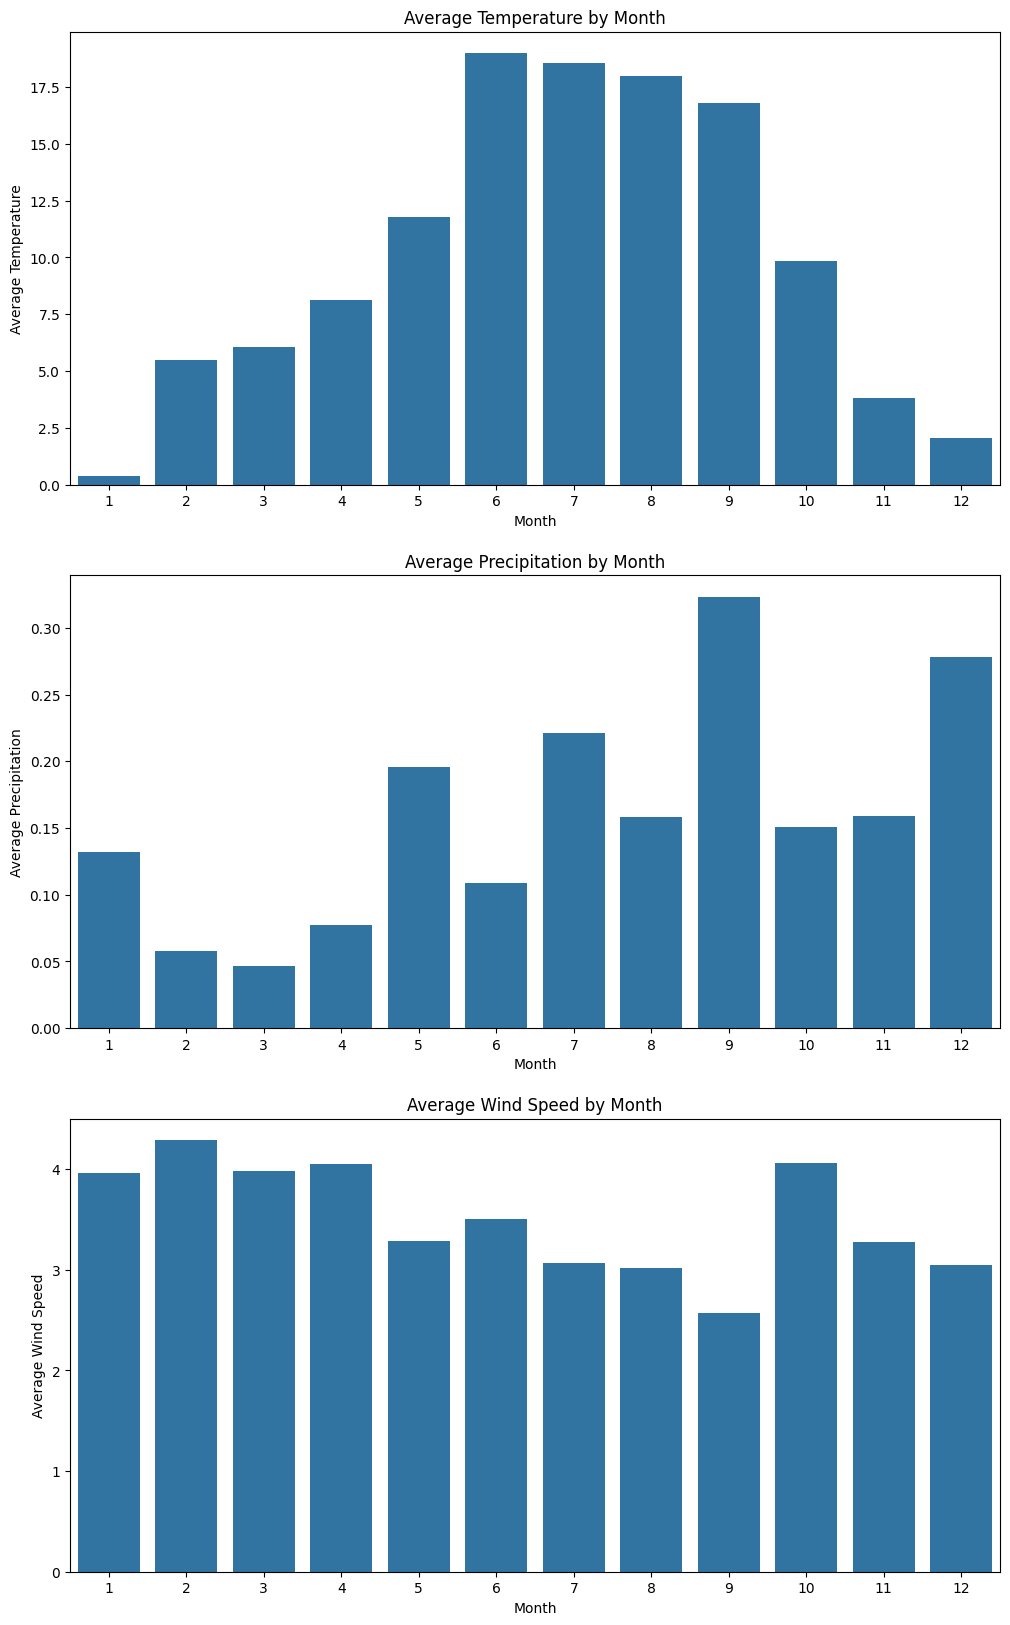

In [12]:
## On affiche les moyennes des températures, précipitation et vent par mois sur 3 graphiques différents

fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(12,20)

monthAggregated = pd.DataFrame(df_weather.groupby(["year","month"])["temperature"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by='temperature', ascending = False) 
sn.barplot(data=monthSorted, x = 'month', y = 'temperature', ax=ax1)
ax1.set(xlabel='Month', ylabel='Average Temperature', title='Average Temperature by Month') 

monthAggregated = pd.DataFrame(df_weather.groupby(["year","month"])["precipitation"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by='precipitation', ascending = False) 
sn.barplot(data=monthSorted, x = 'month', y = 'precipitation', ax=ax2)
ax2.set(xlabel='Month', ylabel='Average Precipitation', title='Average Precipitation by Month') 

monthAggregated = pd.DataFrame(df_weather.groupby(["year","month"])["vent"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by='vent', ascending = False) 
sn.barplot(data=monthSorted, x = 'month', y = 'vent', ax=ax3)
ax3.set(xlabel='Month', ylabel='Average Wind Speed', title='Average Wind Speed by Month') 

Utiliser la méthode [merge()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) pour combiner les données de disponibilité des velo'v avec les données méteo.

In [18]:
## On ajoute les données météo dans le dataframe qui contient les données de disponibilité
df_bikes = df_bikes.merge(df_weather,on=["year","month","day","hour"],suffixes=("",""))
df_bikes.head()

,id_velov,year,month,day,hour,minute,time,bikes,bike_stands,departure30min,arrival30min,daily_departure,daily_arrival,IsWeekday,day_of_week,temperature,vent,precipitation
0,velov-10001,2021,1,1,0,0,2021-01-01 00:00:00+00:00,8,22,0,0,7,6,True,4,-0.35,1.62,0.94
1,velov-10001,2021,1,1,0,30,2021-01-01 00:30:00+00:00,8,22,0,0,7,6,True,4,-0.35,1.62,0.94
2,velov-10001,2021,1,1,1,0,2021-01-01 01:00:00+00:00,7,23,1,0,7,6,True,4,-0.39,1.79,0.98
3,velov-10001,2021,1,1,1,30,2021-01-01 01:30:00+00:00,7,23,0,0,7,6,True,4,-0.39,1.79,0.98
4,velov-10001,2021,1,1,2,0,2021-01-01 02:00:00+00:00,7,23,0,0,7,6,True,4,-0.38,2.18,0.95


## 4. Entraînement d'un modèle de prédiction

### 4.1 Import de la librairie (scikit-learn)

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

### 4.2 Préparation des données pour l'apprentissage

In [19]:
## On fait une copie de notre DataFrame, pour pouvoir revenir aux données initiales si besoin
df_data = df_bikes.copy()


In [20]:
# On sépare le jeu de données en entrées et sorties pour l'apprentissage
print(df_data.columns)
# les inputs correspondent aux données fournis au modèle pour pouvoir apprendre. 

inputs = df_data[["id_velov","month","hour","minute","day_of_week","temperature","vent","precipitation"]]
# la target correspondent aux valeurs que l'on souhaite prédire et donc que le modèle doit apprendre
target = df_data[["bikes"]]



Index(['id_velov', 'year', 'month', 'day', 'hour', 'minute', 'time', 'bikes',
       'bike_stands', 'departure30min', 'arrival30min', 'daily_departure',
       'daily_arrival', 'IsWeekday', 'day_of_week', 'temperature', 'vent',
       'precipitation'],
      dtype='object')


La plupart des méthodes d'apprentissage ne peuvent utiliser que des variables numériques. Il faut donc transformer les variables catégorielles telle que `id_velov` ou `day_of_week` afin qu'elles puissent servir lors de l'apprentissage. 

Pour cela on utilise la fonction [LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) de la librairie scikit-learn. Elle permet de transformer des valeurs de type chaine de caractère en numérique par association. Par exemple : lundi -> 0, mardi -> 1, etc...

In [24]:
# On transforme les variables catégorielles en variables numériques
encoder = LabelEncoder()

# on entraîne l'encoder pour qu'il ai vu toutes les valeurs possibles
encoder.fit(df_stations.id_velov)

# on transforme la colonne id_velov
inputs['id_velov'] = encoder.transform(inputs['id_velov'])

inputs.sample(5)

C:\Users\BastienCAHIER\AppData\Local\Temp\ipykernel_17320\3984884684.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs['id_velov'] = encoder.transform(inputs['id_velov'])


,id_velov,month,hour,minute,day_of_week,temperature,vent,precipitation
2068824,91,2,19,30,2,5.78,3.19,0.00
2681046,118,6,6,30,1,15.59,4.67,0.03
2611559,115,5,6,30,6,11.44,3.27,0.00
5914421,265,2,3,0,0,-1.09,6.38,0.00
3311011,150,12,23,0,4,1.17,5.38,0.07


Une fois que les données sont prêtes et que les variables sont au bon format. Il faut maintenant séparer le jeu de données pour utiliser une partie des données pour l'entraînement et une autre partie pour l'évaluation. 

Pour cela on utilise la méthode [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) qui permet de séparer le jeu de données en 2 de manière aléatoire pour que les jeux d'entrainement et d'évaluation aient les mêmes caractéristiques.

In [25]:
# On sépare le jeu de données en 2 : un jeu d'entraînement et un jeu de test
x_train, x_test, y_train, y_test = train_test_split(
    inputs, target, test_size=0.33,random_state=42
)

# x_train : df d'entrainement avec les entrées (hour, temperature, etc.)
# y_train : df d'entrainement avec la cible (bikes)

# x_test : df de test avec les entrées
# y_test : df de test avec la cible



In [ ]:
#test_size = part du df qui servira pour le test
#random_state=42; sert à la reproductibilité, toujours les mêmes lignes dans les deux DF.

### 4.3 Entraînement supervisé des modèles

L'ensemble des algoritmes d'apprentissage supervisée implémentés dans la librairie Scikit-Learn sont disponibles ici : https://scikit-learn.org/stable/supervised_learning.html

Dans notre cas, nous souhaitons prédire des valeurs continues par opposition aux valeurs discrètes. Nous allons donc utiliser des modèles de régression et non pas des modèles de classification.

Je vous propose de tester et comparer 2 méthodes : [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) et [RandomForestRegressor](https://scikit-learn.org/0.15/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

#### 4.3.1 Linear Regression

In [26]:
# On déclare un modèle de type LinearRegression et on l'entraîne sur le jeu d'entraînement
model_lr = LinearRegression()

model_lr.fit(x_train,y_train)


LinearRegression()

In [28]:
from sklearn.metrics import mean_absolute_error, r2_score
# On utilise le modèle pour faire la prédiction sur le jeu de test
predictions_lr = model_lr.predict(x_test)

print(predictions_lr)


[[8.64200993]
 [9.30094483]
 [8.83974976]
 ...
 [9.17796307]
 [9.38331145]
 [9.34309235]]


#### 4.3.2 Random Forest Regressor

In [32]:
# On déclare un modèle de type RadomForestRegressor et on l'entraîne sur le jeu d'entraînement
model_rf = RandomForestRegressor(
    n_estimators=10,       # Nombre d'arbres
    max_depth=20,        # Profondeur max (None = pas de limite)
    random_state=42,       # Reproductibilité
    n_jobs=-1              # Utiliser tous les CPU
)
model_rf.fit(x_train,y_train)

# !! Cette cellule peut mettre plusieurs minutes à s'executer (entre 5 et 10 min) !! #

c:\Users\BastienCAHIER\miniconda3\envs\geonum-velov-py313\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=42)

* Enregistrer le modèle dans un fichier pour pouvoir le réutiliser plus tard :

In [30]:
from joblib import dump
dump(model_rf, './model-velov-demand-prediction.joblib') 

['./model-velov-demand-prediction.joblib']

* Charger le modèle depuis le fichier :

In [33]:
from joblib import load
model_rf = load('./model-velov-demand-prediction.joblib') 

In [34]:
# On utilise le modèle pour faire la prédiction sur le jeu de test
predictions_rf = model_rf.predict(x_test)
predictions_rf = predictions_rf.reshape(-1,1)

### 4.4 Evaluation et comparaison

Afin d'évaluer nos modèles de prédiction, on utilise la mesure [MAE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) (Mean Absolute Error) : 
$$\frac{\sum_{i=1}^n \left\lvert \hat{y}_i - y_i \right\rvert}{n}$$ 
qui permet de mesurer l'écart moyen absolu entre les prédictions et les valeurs à prédire. Plus cette valeur est faible, meilleur est notre modèle.




In [35]:
# On calcule l'erreur moyenne en comparant les prédictions avec les valeurs qu'il fallait prédire

mae_lr = mean_absolute_error(predictions_lr,y_test)

print('linear regression mae : ', mae_lr)

linear regression mae :  6.225915742978719


In [36]:
# On calcule l'erreur moyenne en comparant les prédictions avec les valeurs qu'il fallait prédire

mae_rf = mean_absolute_error(predictions_rf,y_test)

print('random forest regression mae : ', mae_rf)

random forest regression mae :  1.321209977464402


On observe que l'erreur moyenne est nettement plus faible pour le modèle random forest ! En moyenne l'écart entre la prédiction et la réalité est de 1. Ce qui parait plutôt satisfaisant pour notre tâche. Dans le cas de l'utilisation de ce modèle dans une application, il faudrait prévenir l'utilisateur que la prédiction est en moyenne correcte à plus ou moins 1 vélo !

On souhaite maintenant afficher une évaluation sous forme de graphique. Le jeu de test contenant plus d'un million de lignes, on isole au préalable un échantillon de 100 données.

In [38]:
# On regroupe les valeurs à prédire et les prédictions au sein d'un même tableau
t = np.stack((y_test, predictions_rf, predictions_lr), axis=0)

In [39]:
# On vérifie la taille du tableau
t.shape

(3, 2563056, 1)

In [40]:
# On affiche un aperçu des valeurs
t

array([[[ 1.        ],
        [ 0.        ],
        [16.        ],
        ...,
        [10.        ],
        [ 1.        ],
        [19.        ]],

       [[ 1.72      ],
        [ 0.        ],
        [15.56      ],
        ...,
        [10.        ],
        [ 2.16      ],
        [19.04      ]],

       [[ 8.64200993],
        [ 9.30094483],
        [ 8.83974976],
        ...,
        [ 9.17796307],
        [ 9.38331145],
        [ 9.34309235]]], shape=(3, 2563056, 1))

In [41]:
# On sélectionne un échantillon de 100 prédictions pour afficher la comparaison

idx = np.random.randint(t.shape[1], size=100)
sample = t[:,idx]
print(sample)

[[[16.        ]
  [12.        ]
  [ 0.        ]
  [19.        ]
  [ 8.        ]
  [ 1.        ]
  [17.        ]
  [10.        ]
  [12.        ]
  [16.        ]
  [ 4.        ]
  [ 9.        ]
  [ 2.        ]
  [ 8.        ]
  [ 7.        ]
  [ 4.        ]
  [15.        ]
  [14.        ]
  [15.        ]
  [21.        ]
  [ 1.        ]
  [15.        ]
  [ 0.        ]
  [17.        ]
  [12.        ]
  [ 7.        ]
  [ 0.        ]
  [14.        ]
  [15.        ]
  [ 3.        ]
  [ 9.        ]
  [ 2.        ]
  [ 0.        ]
  [12.        ]
  [29.        ]
  [ 1.        ]
  [ 7.        ]
  [ 7.        ]
  [ 0.        ]
  [ 3.        ]
  [ 1.        ]
  [ 6.        ]
  [ 8.        ]
  [25.        ]
  [ 1.        ]
  [14.        ]
  [ 7.        ]
  [10.        ]
  [17.        ]
  [ 4.        ]
  [ 7.        ]
  [ 9.        ]
  [ 8.        ]
  [ 1.        ]
  [ 0.        ]
  [ 3.        ]
  [ 5.        ]
  [ 9.        ]
  [17.        ]
  [ 7.        ]
  [ 3.        ]
  [ 0.        ]
  [ 3.  

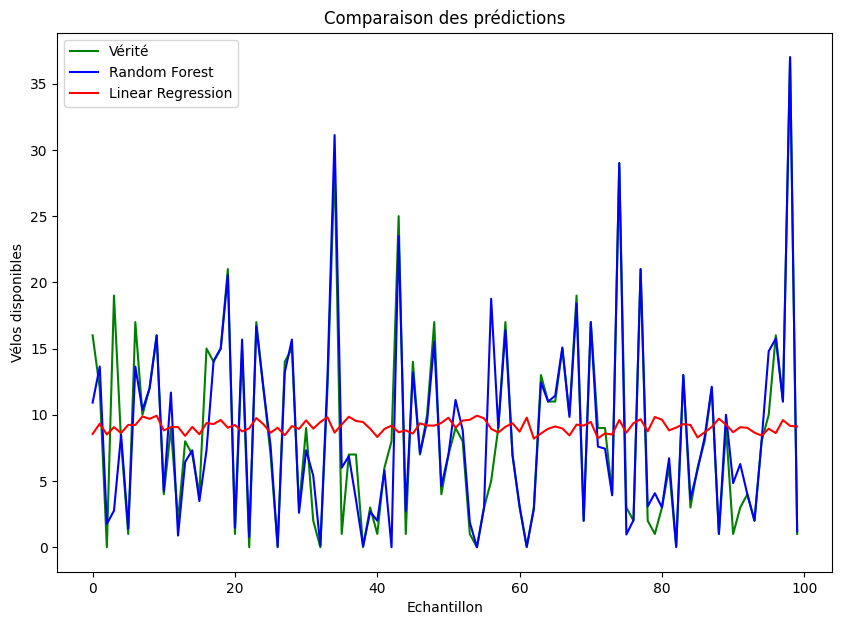

In [42]:
plt.figure(figsize=(10,7))
plt.title("Comparaison des prédictions")
plt.xlabel("Echantillon")
plt.ylabel("Vélos disponibles")
plt.plot(range(100), sample[0], color ="green", label="Vérité")
plt.plot(range(100), sample[1], color ="blue", label="Random Forest")
plt.plot(range(100), sample[2], color ="red", label="Linear Regression")
plt.legend()
plt.show()

On souhaite maintenant afficher le même type de graphique mais au lieu d'afficher la prédiction on veut afficher l'erreur.

In [43]:
err_rf = abs(sample[0]-sample[1])
err_lr = abs(sample[0]-sample[2])

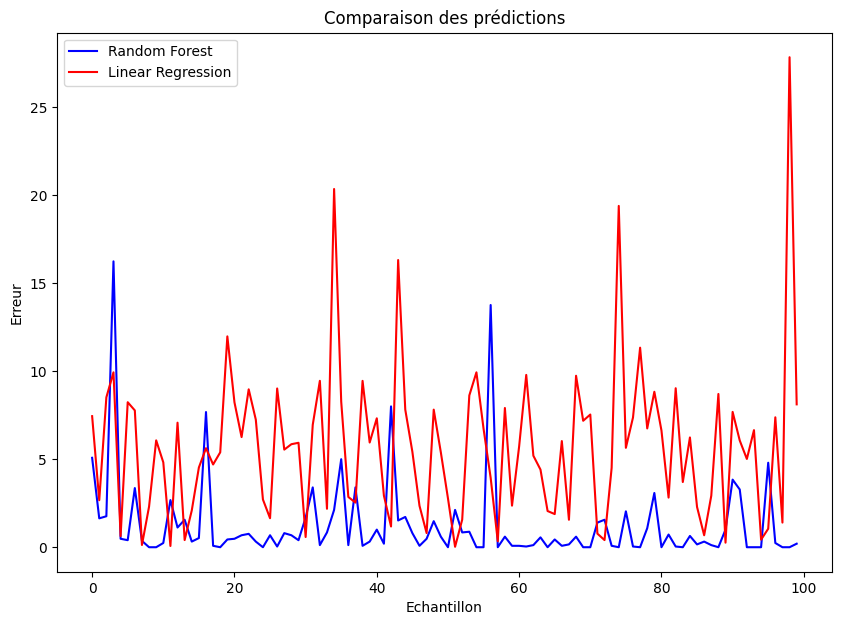

In [44]:
plt.figure(figsize=(10,7))
plt.title("Comparaison des prédictions")
plt.xlabel("Echantillon")
plt.ylabel("Erreur")
plt.plot(range(100), err_rf, color ="blue", label="Random Forest")
plt.plot(range(100), err_lr, color ="red", label="Linear Regression")
plt.legend()
plt.show()

### 4.5 Utilisation du modèle

La météo a-t-elle un impact sur la prédiction ?

Pour le savoir, nous pouvons faire une prédiction de la disponibilité à une station pour une certaine date en faisant varier la météo et observer s'il y a des différences entre les prédictions.

Le modèle prend en entrée 8 paramètres :
- id_velov
- month
- hour
- minute
- day_of_week
- temperature
- vent
- precipitation

On se propose de faire une prédiction pour samedi prochain à 8h à la station 3094 (Gare Part-Dieu). 
On fait la prédiction pour 2 cas différents : beau et mauvais temps
1. Beau temps : température = 20, vent = 1, précipitations = 0
2. Mauvais temps : température = 8, vent = 3, précipitations = 0.10

In [45]:

# encoder le nom de la station
st = encoder.transform(['velov-3094'])[0]

d_nice = [[st, 11, 8, 0, 5, 20, 1, 0]]
d_bad =  [[st, 11, 8, 0, 5, 8, 3, 0.10]]

# on calcule les prédictions
p_nice = model_rf.predict(d_nice)
p_bad = model_rf.predict(d_bad)


c:\Users\BastienCAHIER\miniconda3\envs\geonum-velov-py313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\BastienCAHIER\miniconda3\envs\geonum-velov-py313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [46]:
print(p_nice)
print(p_bad)


[28.52]
[33.]


On remarque donc que la météo a bien un impact sur la prédiction. Il y aura plus de vélos disponibles en cas de mauvais temps que de beau temps !

## Exercices

En reprenant le code des séances précédentes proposer une carte de la disponibilité des vélo'v pour l'ensemble des stations basée sur les prédictions de samedi prochain à 8h.

In [47]:
df_stations.head

<bound method NDFrame.head of         id_velov   latitude  longitude
0    velov-10056  45.779112   4.871952
1     velov-9013  45.787384   4.814374
2     velov-5044  45.759797   4.796627
3     velov-9014  45.783341   4.811433
4    velov-10058  45.767126   4.892150
..           ...        ...        ...
342   velov-9050  45.783637   4.794525
343   velov-6020  45.774527   4.848382
344   velov-2010  45.743392   4.815816
345   velov-5007  45.757906   4.813135
346  velov-10012  45.767981   4.887219

[347 rows x 3 columns]>

In [ ]:
df_prediction = df_stations.copy()

#Encoder les stations
df_prediction['id_velov'] = encoder.transform(df_prediction['id_velov'])

#Ajouter les paramètres de prédiction
df_prediction['month'] = 11
df_prediction['hour'] = 8
df_prediction['minute'] = 0
df_prediction['day_of_week'] = 5
df_prediction['temperature'] = 4
df_prediction['vent'] = 2
df_prediction['precipitation'] = 0.17

df_for_predict = df_prediction.drop(columns = ['latitude','longitude'])

#assigner la prédiction dans une nouvelle colonne
df_prediction['bike_predict'] = model_rf.predict(df_for_predict)

#remettre l'identifiant "clair" des stations
df_prediction['id_velov'] = encoder.inverse_transform(df_prediction['id_velov'])


In [262]:
print(df_prediction.sample(10))

        id_velov   latitude  longitude  month  hour  minute  day_of_week  \
218   velov-3002  45.760119   4.858732     11     8       0            5   
309   velov-9051  45.786525   4.797071     11     8       0            5   
322   velov-9004  45.779744   4.804567     11     8       0            5   
25   velov-10092  45.771558   4.890370     11     8       0            5   
294   velov-9033  45.767356   4.805640     11     8       0            5   
332   velov-6016  45.765988   4.862092     11     8       0            5   
146  velov-10088  45.766243   4.897872     11     8       0            5   
343   velov-6020  45.774527   4.848382     11     8       0            5   
199   velov-2002  45.758262   4.830439     11     8       0            5   
9     velov-2036  45.759470   4.830145     11     8       0            5   

     temperature  vent  precipitation  bike_predict  
218           20     1              0          0.96  
309           20     1              0          2.52  
3

In [ ]:
Lyon = [45.76, 4.85]

def gen_map_dep_arr(df):

    map = folium.Map(location = Lyon,
                 zoom_start = 13, 
                 tiles = "CartoDB positron") # sombre : CartoDB dark_matter
    
    for index, row in df.iterrows():
        nb_bikes = np.round(row['bike_predict'])
        radius = np.abs(nb_bikes) 
        if np.isnan(radius):
            radius = 1
            
        radius *= 0.7
        color = "#049BFF" # blue
    
        lat = row['latitude']
        lon = row['longitude']

        folium.CircleMarker(location = [lat,lon], 
                            radius = int(radius), 
                            popup = row['id_velov'] + ' velos dispo: ' + str(nb_bikes), 
                            color = color, 
                            fill_opacity = 0.5).add_to(map)
    return map

gen_map_dep_arr(df_prediction)

Proposer une carte permettant de visualiser la différence entre beau et mauvais temps pour la même date.

In [275]:
df_prediction_bad = df_stations.copy()

#Encoder les stations
df_prediction_bad['id_velov'] = encoder.transform(df_prediction_bad['id_velov'])

#Ajouter les paramètres de prédiction
df_prediction_bad['month'] = 11
df_prediction_bad['hour'] = 8
df_prediction_bad['minute'] = 0
df_prediction_bad['day_of_week'] = 5
df_prediction_bad['temperature'] = 8
df_prediction_bad['vent'] = 3
df_prediction_bad['precipitation'] = 0.2

df_for_predict = df_prediction_bad.drop(columns = ['latitude','longitude'])

#assigner la prédiction dans une nouvelle colonne
df_prediction_bad['bike_predict_bad'] = model_rf.predict(df_for_predict)
#remettre l'identifiant "clair" des stations
df_prediction_bad['id_velov'] = encoder.inverse_transform(df_prediction_bad['id_velov'])

#ne conserver que les champs id_velov & bad_predict
df_prediction_bad = df_prediction_bad[['id_velov','bike_predict_bad']]

#créer un nouveau DF joint entre les bonnes et mauvaises prédictions
df_prediction_merged = df_prediction.merge(df_prediction_bad,on='id_velov',suffixes=('',''))

print(df_prediction_merged.sample(10))


        id_velov   latitude  longitude  month  hour  minute  day_of_week  \
260   velov-8035  45.747249   4.865286     11     8       0            5   
88    velov-7012  45.729501   4.829690     11     8       0            5   
271   velov-4007  45.779290   4.820245     11     8       0            5   
32   velov-10004  45.776221   4.862648     11     8       0            5   
175   velov-6005  45.765766   4.844732     11     8       0            5   
110   velov-7022  45.743926   4.841522     11     8       0            5   
174   velov-1012  45.765811   4.836896     11     8       0            5   
194  velov-10038  45.779046   4.866778     11     8       0            5   
283   velov-3016  45.759342   4.842228     11     8       0            5   
189  velov-10063  45.758389   4.885613     11     8       0            5   

     temperature  vent  precipitation  bike_predict  bike_predict_bad  
260           20     1              0         10.44             13.16  
88            20   

In [288]:
def gen_map_dep_arr(df):

    map = folium.Map(location = Lyon,
                 zoom_start = 13, 
                 tiles = "CartoDB positron") # sombre : CartoDB dark_matter
    
    for index, row in df.iterrows():
        
        nb_bikes = np.round(row['bike_predict'])
        nb_bikes_bad = np.round(row['bike_predict_bad'])
        delta = nb_bikes - nb_bikes_bad
        radius = np.abs(delta) 
        if np.isnan(radius):
            radius = 1
        radius *= 1.5
        if radius == 0:
            radius = 1
            
        if delta > 0: 
            color = '#fa294f' # red
        elif delta < 0: 
            color = '#2e93f9' # blue
        else:
            color = '#646363' # grey
            
        lat = row['latitude']
        lon = row['longitude']

        folium.CircleMarker(location = [lat,lon], 
                            radius = int(radius), 
                            popup = row['id_velov'] + 
                                ' beau temps : ' + str(nb_bikes) + 
                                ' mauvais temps: ' + str(nb_bikes_bad) +
                                ' variation: '+ str(delta), 
                            color = color, 
                            fill_opacity = 0.5).add_to(map)
    return map

gen_map_dep_arr(df_prediction_merged)